Data set paris

In [ ]:
import pandas as pd
import requests
import os

WINNING_DATE = "2024-06-10"

In [20]:
DATA_URL = f"http://data.insideairbnb.com/france/ile-de-france/paris/{WINNING_DATE}/data/listings.csv.gz"
SAVE_PATH = "data/paris_listings_final.csv.gz"

print(f"--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE ({WINNING_DATE}) ---")

# 1. TÉLÉCHARGEMENT
if not os.path.exists(SAVE_PATH):
    print(f"Téléchargement depuis : {DATA_URL}")
    try:
        response = requests.get(DATA_URL, stream=True)
        if response.status_code == 200:
            with open(SAVE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            print("✅ Téléchargement terminé !")
        else:
            print("❌ Erreur de téléchargement (404 ou autre).")
    except Exception as e:
        print(f"❌ Erreur technique : {e}")
else:
    print("ℹ️ Le fichier existe déjà.")

# 2. CHARGEMENT ET NETTOYAGE PRÉLIMINAIRE
print("\n--- PRÉPARATION DU DATASET ---")
# On charge
df = pd.read_csv(SAVE_PATH, compression='gzip')
print(f"Taille brute : {len(df)} lignes")

# On nettoie le prix
# Conversion string -> float
df['price_clean'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')

# On supprime les lignes sans prix (les fameux 18.4%)
df_clean = df.dropna(subset=['price_clean'])

print(f"Taille après suppression des sans-prix : {len(df_clean)} lignes")
print(f"Perte de données : {100 - (len(df_clean)/len(df)*100):.1f}% (Acceptable)")

# 3. VÉRIFICATION AMENITIES
sample_amenity = str(df_clean['amenities'].iloc[0])
print(f"\nExemple d'amenities : {sample_amenity[:50]}...")

if "wifi" in sample_amenity.lower() or "[" in sample_amenity:
    print("✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !")
    
    # On sauvegarde cette version propre pour ne plus avoir à retélécharger
    df_clean.to_csv(f"data/paris_listings_ready_{WINNING_DATE}.csv", index=False)
    print(f"💾 Fichier de travail sauvegardé sous : 'data/paris_listings_ready_{WINNING_DATE}.csv'")
else:
    print("⚠️ ATTENTION : Les amenities semblent vides.")

--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE (2024-06-10) ---
ℹ️ Le fichier existe déjà.

--- PRÉPARATION DU DATASET ---
Taille brute : 95885 lignes
Taille après suppression des sans-prix : 74579 lignes
Perte de données : 22.2% (Acceptable)

Exemple d'amenities : ["Smart lock", "Smoke alarm", "Cooking basics", "H...
✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !
💾 Fichier de travail sauvegardé sous : 'data/paris_listings_ready_2024-06-10.csv'


Audit of dataset + feature selection for the model


2. Chargement du fichier : data/paris_listings_ready_2024-06-10.csv...


   -> 34 colonnes supprimées (Liées au Host ou Scrapping).
   -> Reste : 42 colonnes axées sur le LOGEMENT.

3. Génération de l'audit de complétude...


C:\Users\User\AppData\Local\Temp\ipykernel_19900\673484761.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)


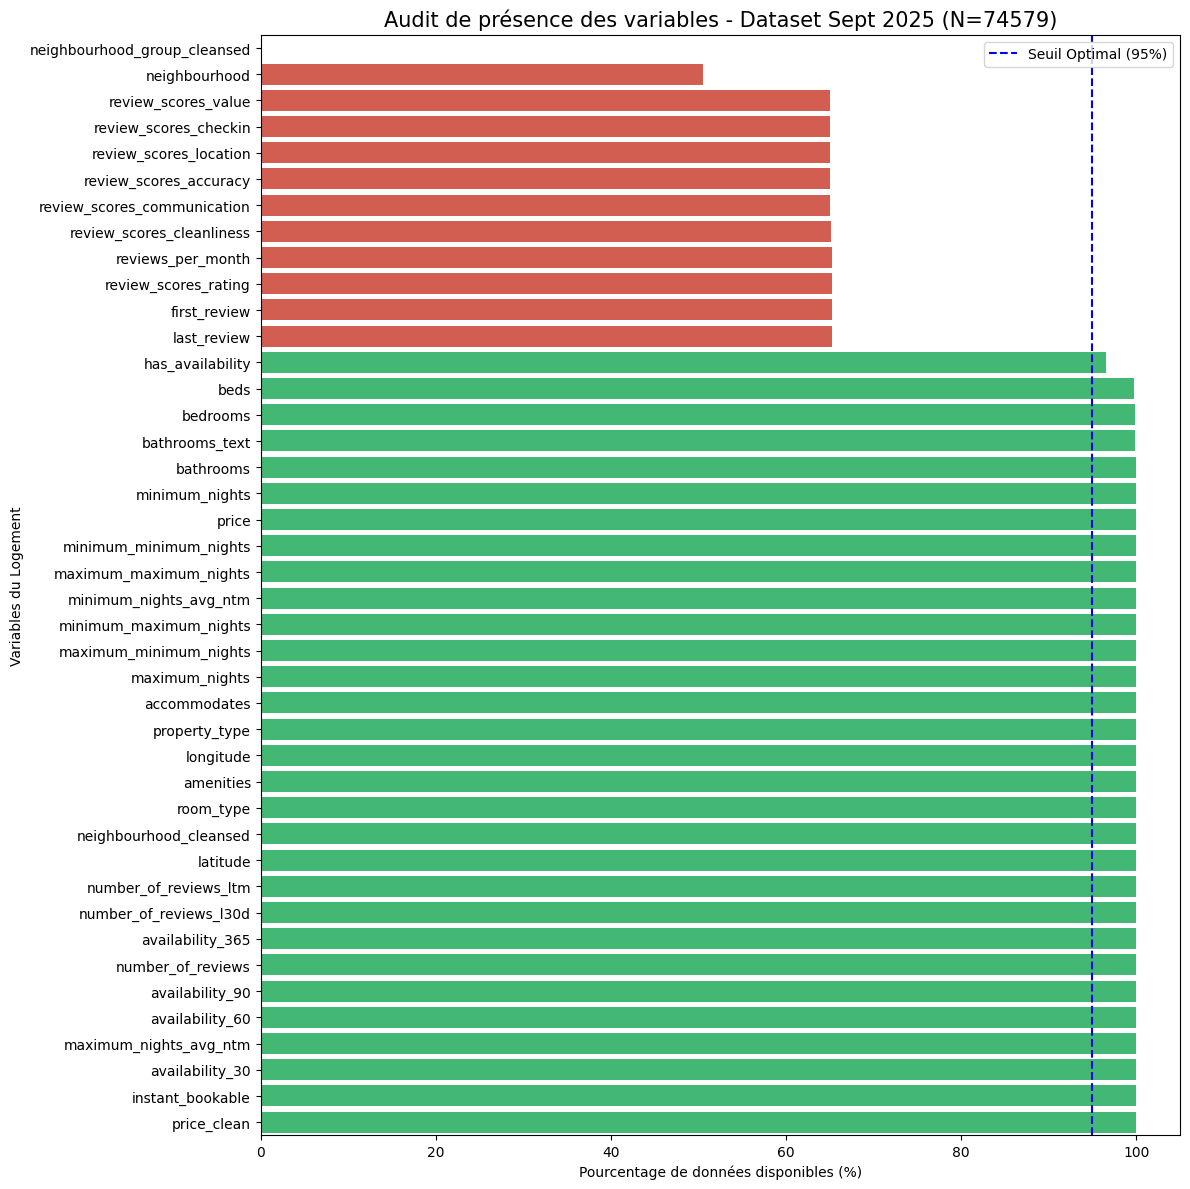


--- ⚠️ VARIABLES VIDES (0% de données) ---
['neighbourhood_group_cleansed']

--- CHECK CRITIQUE : AMENITIES ---
✅ AMENITIES : 100.00% (C'est bon !)


In [21]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

RAW_FILE_PATH = f"data/paris_listings_ready_{WINNING_DATE}.csv"

if not os.path.exists(RAW_FILE_PATH):
    print(f"⚠️ ERREUR : Le fichier {RAW_FILE_PATH} est introuvable.")
    print("Assurez-vous d'avoir lancé le script de téléchargement précédent.")
else:
    # ==============================================================================
    # 2. CHARGEMENT & FILTRAGE (Scraping & Host)
    # ==============================================================================
    print(f"\n2. Chargement du fichier : {RAW_FILE_PATH}...")
    df = pd.read_csv(RAW_FILE_PATH)

    # Définition des colonnes techniques à supprimer (Scraping)
    scraping_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 
        'description', 'neighborhood_overview', 'picture_url', 'calendar_updated', 
        'calendar_last_scraped', 'license'
    ]

    # Identification automatique des colonnes "Host" (Hôte)
    host_cols = [c for c in df.columns if c.startswith('host_') or c.startswith('calculated_host_')]

    # Liste totale à supprimer
    cols_to_drop = scraping_cols + host_cols

    # On ne supprime que celles qui existent vraiment dans le fichier
    existing_drops = [c for c in cols_to_drop if c in df.columns]
    df_audit = df.drop(columns=existing_drops)

    print(f"   -> {len(existing_drops)} colonnes supprimées (Liées au Host ou Scrapping).")
    print(f"   -> Reste : {df_audit.shape[1]} colonnes axées sur le LOGEMENT.")

    # ==============================================================================
    # 3. AUDIT VISUEL (Barplot)
    # ==============================================================================
    print("\n3. Génération de l'audit de complétude...")

    # Calcul du % de présence
    presence = df_audit.notnull().mean() * 100
    presence_df = presence.reset_index()
    presence_df.columns = ['Variable', 'Taux_Presence']
    presence_df = presence_df.sort_values(by='Taux_Presence', ascending=True)

    # Visualisation
    plt.figure(figsize=(12, 12))
    # Code couleur : Rouge si < 90%, Vert sinon
    colors = ['#e74c3c' if x < 90 else '#2ecc71' for x in presence_df['Taux_Presence']]

    sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)

    plt.axvline(x=95, color='blue', linestyle='--', label='Seuil Optimal (95%)')
    plt.title(f'Audit de présence des variables - Dataset Sept 2025 (N={len(df)})', fontsize=15)
    plt.xlabel('Pourcentage de données disponibles (%)')
    plt.ylabel('Variables du Logement')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Affichage des variables vides à 100% (à supprimer immédiatement)
    print("\n--- ⚠️ VARIABLES VIDES (0% de données) ---")
    empty_cols = presence_df[presence_df['Taux_Presence'] == 0]['Variable'].tolist()
    print(empty_cols if empty_cols else "Aucune variable totalement vide.")
    
    # CHECK SPECIFIQUE AMENITIES
    print("\n--- CHECK CRITIQUE : AMENITIES ---")
    amenities_score = presence_df[presence_df['Variable'] == 'amenities']['Taux_Presence'].values
    if len(amenities_score) > 0 and amenities_score[0] > 99:
         print(f"✅ AMENITIES : {amenities_score[0]:.2f}% (C'est bon !)")
    else:
         print(f"❌ AMENITIES : {amenities_score}% (Problème persistant)")

Verification of presence of amenities and prices in the dataset


--- Distribution du Prix (74579 lignes) ---
count    74579.000000
mean       289.075155
std        684.010923
min         10.000000
25%        109.000000
50%        164.000000
75%        290.000000
max      72000.000000
Name: price_clean, dtype: float64


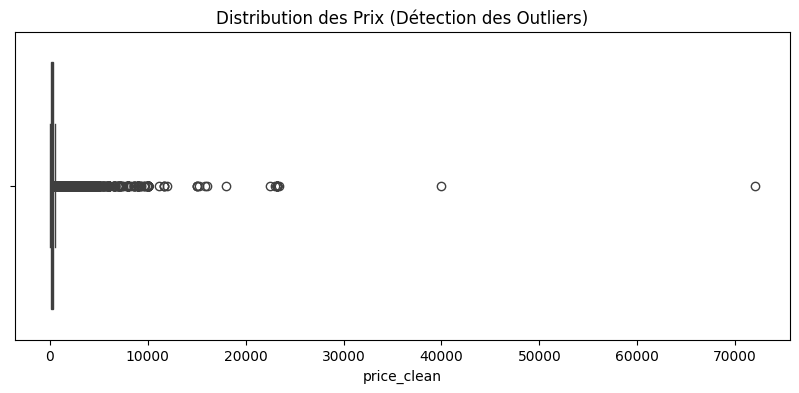


--- Structure des Amenities (Exemple Ligne 0) ---
Type : <class 'str'>
Contenu : ["Smart lock", "Smoke alarm", "Cooking basics", "Hangers", "Wifi", "Dishes and silverware", "Hair dryer", "Children\u2019s books and toys", "Kitchen",...
Parsing Test : OK (15 équipements détectés)


In [22]:
# A. Analyse du PRIX
print(f"\n--- Distribution du Prix ({len(df)} lignes) ---")
print(df['price_clean'].describe())

# Visualisation rapide des prix pour voir les outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price_clean'])
plt.title("Distribution des Prix (Détection des Outliers)")
plt.show()

# B. Analyse des AMENITIES
print("\n--- Structure des Amenities (Exemple Ligne 0) ---")
amenity_sample = df['amenities'].iloc[0]
print(f"Type : {type(amenity_sample)}")
print(f"Contenu : {str(amenity_sample)[:150]}...") # On affiche les 150 premiers caractères

# Test de parsing
import json
try:
    # On teste si c'est du JSON standard
    test_parse = json.loads(amenity_sample.replace("'", '"')) if isinstance(amenity_sample, str) else amenity_sample
    print(f"Parsing Test : OK ({len(test_parse)} équipements détectés)")
except:
    print("Parsing Test : Format complexe (nécessitera un nettoyage spécifique)")

Dropping of columns that are not useful for the model (id, name, host_name, etc.)

In [23]:
import pandas as pd

# (Assure-toi que 'df' est chargé avec le fichier 'paris_listings_ready.csv')
# df = pd.read_csv("data/paris_listings_ready.csv")

print("\n=== 2. SUPPRESSION MASSIVE (Rouges + Scraping + Host) ===")

# A. Indicateurs Rouges / Manquants (Ta liste)
red_flags = [
    'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license',
    'neighbourhood', 'neighborhood_overview', 'first_review', 'last_review',
    'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value'
]

# B. Métadonnées de Scraping (Inutile pour le modèle)
scraping_metadata = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 
    'picture_url', 'calendar_last_scraped', 'name', 'description' 
    # 'name' et 'description' sont du texte libre non structuré, on utilise amenities à la place
]

# C. Données de l'Hôte (On juge le bien, pas la personne)
host_info = [
    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 
    'host_about', 'host_response_time', 'host_response_rate', 
    'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'host_listings_count', 
    'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 
    'host_identity_verified', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 
    'calculated_host_listings_count_shared_rooms'
]

# D. Redondances (On a déjà price_clean)
redundant = ['price', 'has_availability'] 

# Fusion des listes
cols_to_drop = red_flags + scraping_metadata + host_info + redundant

# Suppression sécurisée
existing_drops = [c for c in cols_to_drop if c in df.columns]
df_lean = df.drop(columns=existing_drops)

print(f"Colonnes supprimées : {len(existing_drops)}")
print(f"Colonnes restantes : {len(df_lean.columns)}")

print("\n=== 3. AUDIT FINAL & DISTRIBUTION DES SURVIVANTS ===")

# On sépare les numériques des objets pour une analyse adaptée
num_cols = df_lean.select_dtypes(include=['number']).columns
obj_cols = df_lean.select_dtypes(include=['object']).columns

print(f"\n--- A. Variables Numériques ({len(num_cols)}) ---")
# On affiche un résumé statistique complet
print(df_lean[num_cols].describe().T[['count', 'mean', 'min', '50%', 'max']])

print(f"\n--- B. Variables Catégorielles / Texte ({len(obj_cols)}) ---")
for col in obj_cols:
    unique_count = df_lean[col].nunique()
    print(f"\n> Colonne : {col} (uniques: {unique_count})")
    if unique_count < 15:
        # Si peu de catégories, on affiche la distribution
        print(df_lean[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    else:
        # Sinon on montre juste un exemple
        print(f"  Exemple : {df_lean[col].iloc[0][:50]}...")



=== 2. SUPPRESSION MASSIVE (Rouges + Scraping + Host) ===
Colonnes supprimées : 49
Colonnes restantes : 27

=== 3. AUDIT FINAL & DISTRIBUTION DES SURVIVANTS ===

--- A. Variables Numériques (21) ---
                          count           mean        min         50%  \
latitude                74579.0      48.863959  48.816080   48.865132   
longitude               74579.0       2.341852   2.227178    2.345910   
accommodates            74579.0       3.381555   1.000000    3.000000   
bedrooms                74457.0       1.340075   0.000000    1.000000   
beds                    74427.0       1.573381   0.000000    1.000000   
minimum_nights          74579.0       9.976039   1.000000    3.000000   
maximum_nights          74579.0   29205.314177   1.000000  365.000000   
minimum_minimum_nights  74579.0       8.603829   1.000000    2.000000   
maximum_minimum_nights  74579.0      14.174727   1.000000    3.000000   
minimum_maximum_nights  74579.0   29218.217434   1.000000  365.000000 

C:\Users\User\AppData\Local\Temp\ipykernel_19900\3103840427.py:54: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df_lean.select_dtypes(include=['object']).columns



> Colonne : amenities (uniques: 65363)
  Exemple : ["Smart lock", "Smoke alarm", "Cooking basics", "H...

> Colonne : instant_bookable (uniques: 2)
instant_bookable
f    75.3%
t    24.7%
Name: proportion, dtype: str


Encoding amneties, d'abbord audit

=== TOP 50 DES AMENITIES LES PLUS FRÉQUENTES ===
                            count
Kitchen                     69676
Wifi                        66596
Smoke alarm                 57304
Hot water                   56073
Essentials                  53450
Hair dryer                  52177
Dishes and silverware       51611
Bed linens                  50821
Cooking basics              50625
Iron                        48111
Refrigerator                47818
Hangers                     46897
Washer                      46746
Microwave                   41038
TV                          40045
Heating                     38180
Hot water kettle            37225
Shampoo                     35881
Dedicated workspace         35842
Cleaning products           34886
Wine glasses                32275
Baking sheet                31096
Freezer                     30680
Toaster                     30522
Oven                        30233
Dining table                30083
Dishwasher                  29822

<Axes: title={'center': 'Top 30 Amenities à Paris'}>

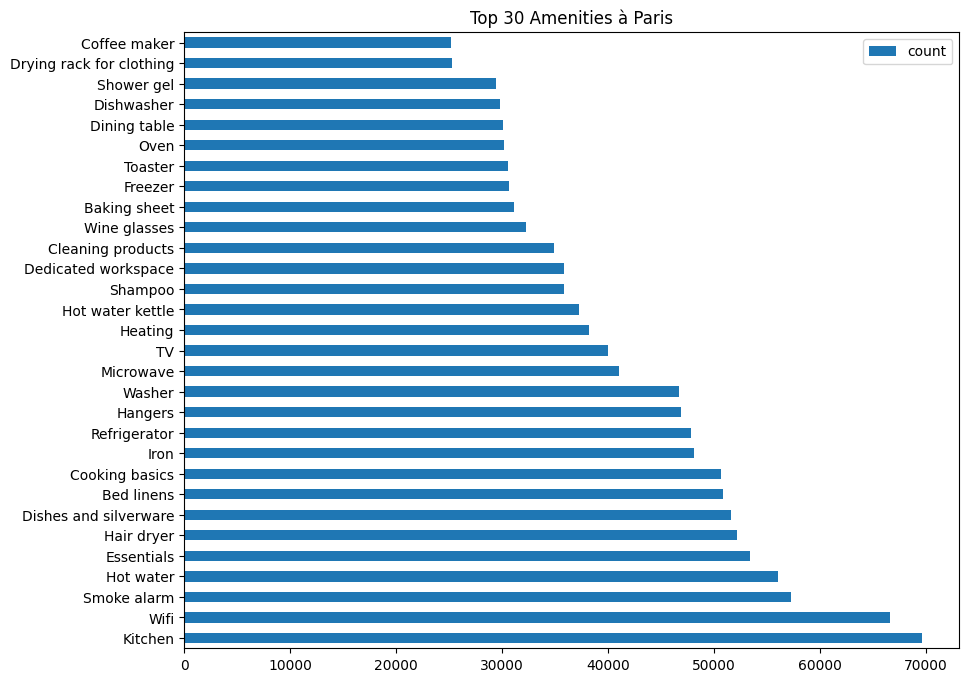

In [24]:
from collections import Counter
import json

# 1. On transforme les strings en listes réelles
def get_amenities_list(x):
    try:
        # Gère le format JSON ["Wifi", "TV"] ou le format simple
        return json.loads(x.replace("'", '"')) if isinstance(x, str) else x
    except:
        return []

all_amenities = []
df_lean['amenities'].apply(get_amenities_list).apply(all_amenities.extend)

# 2. On compte les occurrences
amenity_counts = Counter(all_amenities)
amenity_freq = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
amenity_freq = amenity_freq.sort_values(by='count', ascending=False)

# 3. Affichage du Top 50 pour faire votre choix
print("=== TOP 50 DES AMENITIES LES PLUS FRÉQUENTES ===")
print(amenity_freq.head(50))

# Visualisation de la "longue traîne"
amenity_freq.head(30).plot(kind='barh', figsize=(10, 8), title="Top 30 Amenities à Paris")

Creation of a new column "price_category" based on the price column, with categories "low", "medium", and "high" for classification purposes.

In [25]:
import pandas as pd
import numpy as np

df_final = df_lean.copy()
df_final['amen_raw'] = df_final['amenities'].astype(str).str.lower()

# --- A. LES POWER ITEMS (One-Hot / Binaire) ---
# Ces items sont si impactants qu'ils méritent leur propre colonne
power_items = {
    'has_ac': 'air conditioning',
    'has_elevator': 'elevator',
    'has_parking': 'parking',
    'has_dishwasher': 'dishwasher',
    'has_washing_machine': 'washer'
}

for col, key in power_items.items():
    df_final[col] = df_final['amen_raw'].apply(lambda x: 1 if key in x else 0)

# --- B. LES SCORES THÉMATIQUES GRANULAIRES ---
# On augmente la précision : chaque item trouvé ajoute +1 au score du thème
themes = {
    'score_chef_kitchen': ['oven', 'stove', 'refrigerator', 'freezer', 'baking sheet', 'wine glasses', 'dining table'],
    'score_coffee_station': ['coffee maker', 'hot water kettle', 'coffee', 'toaster'],
    'score_wellness_luxe': ['pool', 'sauna', 'jacuzzi', 'hot tub', 'bathtub', 'shower gel', 'shampoo', 'body soap'],
    'score_comfort_sleep': ['bed linens', 'extra pillows and blankets', 'room-darkening shades', 'heating', 'central heating'],
    'score_work_tech': ['dedicated workspace', 'tv', 'wifi', 'ethernet connection'],
    'score_logistics': ['self check-in', 'lockbox', 'luggage dropoff allowed', 'cleaning products', 'iron', 'hair dryer'],
    'score_safety': ['smoke alarm', 'carbon monoxide alarm', 'first aid kit', 'fire extinguisher']
}

for theme_name, keys in themes.items():
    df_final[theme_name] = df_final['amen_raw'].apply(lambda x: sum(1 for k in keys if k in x))

# --- C. LE SYSTÈME DE STANDING THERMIQUE ---
def get_thermal_standing(x):
    if 'air conditioning' in x: return 2
    if 'portable fans' in x: return 1
    return 0
df_final['standing_thermal'] = df_final['amen_raw'].apply(get_thermal_standing)


In [26]:
# Force l'affichage de toutes les colonnes dans le notebook
pd.set_option('display.max_columns', None)

print(df_final.head())

  neighbourhood_cleansed  latitude  longitude                property_type  \
0           Observatoire  48.83191    2.31870           Entire rental unit   
1               Panthéon  48.83918    2.34699  Private room in rental unit   
2         Hôtel-de-Ville  48.85247    2.35835           Entire rental unit   
3         Hôtel-de-Ville  48.85909    2.35315           Entire rental unit   
4      Buttes-Montmartre  48.88912    2.36154                 Entire condo   

         room_type  accommodates bathrooms_text  bedrooms  beds  \
0  Entire home/apt             2         1 bath       1.0   0.0   
1     Private room             1      1.5 baths       1.0   1.0   
2  Entire home/apt             2         1 bath       0.0   1.0   
3  Entire home/apt             4         1 bath       2.0   1.0   
4  Entire home/apt             1         1 bath       1.0   1.0   

                                           amenities  minimum_nights  \
0  ["Smart lock", "Smoke alarm", "Cooking basics"...    

Création df sans les colonnes inutiles pour le modèle modulable pour d'autres villes

In [ ]:
import pandas as pd
import numpy as np
import re

# ==============================================================================
# FONCTION OPTIMISÉE POUR MULTI-VILLES (ANTI-LEAKAGE)
# ==============================================================================
def process_city_data(df_input, city_name, coords_center):
    """
    Prépare les données d'une ville avec des features TRANSFÉRABLES.
    
    ⚠️ ANTI-LEAKAGE : N'utilise PAS le prix pour encoder les quartiers.
    Compatible pour la généralisation de domaine (cross-city).
    
    Args:
        df_input: DataFrame brut de la ville
        city_name: 'Paris', 'Lyon', 'Marseille'...
        coords_center: (lat, lon) du centre-ville
    
    Returns:
        DataFrame avec features généralisables + price_clean conservé
    """
    df = df_input.copy()
    print(f"🌍 Traitement de {city_name}...")

    # --- A. GESTION INTELLIGENTE DU PRIX ---
    if 'price_clean' in df.columns:
        print("   ✅ Colonne 'price_clean' détectée.")
    elif 'price' in df.columns:
        print("   🔧 Nettoyage de 'price'...")
        if df['price'].dtype == 'object':
            df['price_clean'] = df['price'].astype(str).str.replace(r'[$,€]', '', regex=True)
        else:
            df['price_clean'] = df['price']
        df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')
    else:
        raise KeyError("❌ ERREUR : Aucune colonne de prix trouvée.")

    # Suppression NaN prix + Outliers
    df = df.dropna(subset=['price_clean'])
    q1, q99 = df['price_clean'].quantile([0.01, 0.99])
    df = df[(df['price_clean'] >= q1) & (df['price_clean'] <= q99)]
    print(f"   📊 {len(df)} listings après filtrage outliers")

    # --- B. GÉOGRAPHIE RELATIVE (Normalisée) ---
    lat_center, lon_center = coords_center
    df['dist_raw'] = np.sqrt((df['latitude'] - lat_center)**2 + (df['longitude'] - lon_center)**2)
    city_radius = df['dist_raw'].quantile(0.95)
    df['dist_to_center'] = np.clip(df['dist_raw'] / city_radius, 0, 1)  # Clippé !
    df = df.drop(columns=['latitude', 'longitude', 'dist_raw'])

    # --- C. BATHROOMS & INSTANT BOOKABLE ---
    def clean_bath(text):
        if pd.isna(text): return 1.0
        text = str(text).lower()
        if 'half' in text: return 0.5
        res = re.findall(r"(\d+(\.\d+)?)", text)
        return float(res[0][0]) if res else 1.0
    
    if 'bathrooms_text' in df.columns:
        df['bathrooms_qty'] = df['bathrooms_text'].apply(clean_bath)
        df = df.drop(columns=['bathrooms_text'])

    if 'instant_bookable' in df.columns:
        df['instant_bookable_num'] = df['instant_bookable'].replace({
            't': 1, 'f': 0, True: 1, False: 0
        }).fillna(0).astype(int)
        df = df.drop(columns=['instant_bookable'])

    # --- D. AMENITIES (Indépendants du prix) ---
    if 'amenities' in df.columns:
        df['amen_str'] = df['amenities'].astype(str).str.lower()
        
        # Power Items
        df['has_ac'] = df['amen_str'].str.contains('air conditioning|clim', regex=True).astype(int)
        df['has_elevator'] = df['amen_str'].str.contains('elevator|ascenseur', regex=True).astype(int)
        df['has_dishwasher'] = df['amen_str'].str.contains('dishwasher|lave-vaisselle', regex=True).astype(int)
        df['has_parking'] = df['amen_str'].str.contains('parking', regex=True).astype(int)
        df['has_washing_machine'] = df['amen_str'].str.contains('washer|lave-linge', regex=True).astype(int)
        
        # Scores Thématiques
        kitchen_items = ['stove', 'oven', 'refrigerator', 'cooking basics', 'freezer']
        df['score_chef_kitchen'] = df['amen_str'].apply(lambda x: sum(1 for k in kitchen_items if k in x))
        
        tech_items = ['wifi', 'dedicated workspace', 'tv', 'ethernet']
        df['score_work_tech'] = df['amen_str'].apply(lambda x: sum(1 for k in tech_items if k in x))
        
        wellness_items = ['pool', 'jacuzzi', 'sauna', 'gym']
        df['score_wellness_luxe'] = df['amen_str'].apply(lambda x: sum(1 for k in wellness_items if k in x))
        
        coffee_items = ['coffee maker', 'espresso', 'nespresso', 'coffee']
        df['score_coffee_station'] = df['amen_str'].apply(lambda x: sum(1 for k in coffee_items if k in x))
        
        df = df.drop(columns=['amenities', 'amen_str'])
        print(f"   ✅ Amenities encodées (9 features)")

    # --- E. QUARTIER : POPULARITÉ (PAS PRIX) ⚠️ CLEF ANTI-LEAKAGE ---
    if 'neighbourhood_cleansed' in df.columns:
        # ✅ BON : Fréquence (popularity)
        neigh_freq = df['neighbourhood_cleansed'].value_counts(normalize=True)
        df['neigh_popularity'] = df['neighbourhood_cleansed'].map(neigh_freq).fillna(0)
        
        # On garde temporairement neighbourhood_cleansed (utile pour analyse)
        print(f"   ✅ Popularité quartier (max: {neigh_freq.max():.1%})")

    # --- F. PROPERTY TYPE & ROOM TYPE (One-Hot) ---
    if 'property_type' in df.columns:
        def group_prop(x):
            x = str(x).lower()
            if 'entire' in x or 'apartment' in x or 'house' in x: 
                return 'entire_unit'
            if 'private' in x or 'room' in x: 
                return 'private_room'
            if 'hotel' in x: 
                return 'hotel'
            return 'other'
        
        df['prop_group'] = df['property_type'].apply(group_prop)
        df = pd.get_dummies(df, columns=['prop_group'], prefix='pg', drop_first=False)
        df = df.drop(columns=['property_type'])

    if 'room_type' in df.columns:
        df = pd.get_dummies(df, columns=['room_type'], prefix='rt', drop_first=False)

    # --- G. LABEL VILLE ---
    df['city_label'] = city_name

    # --- H. NETTOYAGE FINAL ---
    # Supprimer colonnes inutiles/dangereuses
    cols_drop = [
        'id', 'scrape_id', 'host_id', 'amen_raw', 
        'minimum_nights', 'maximum_nights',
        'availability_30', 'availability_60', 'availability_90', 'availability_365',
        'price', 'neighbourhood_cleansed'  # On garde price_clean !
    ]
    df = df.drop(columns=[c for c in cols_drop if c in df.columns])
    
    # Supprimer colonnes textuelles restantes (sauf neighbourhood_cleansed qu'on garde pour l'instant)
    text_cols = df.select_dtypes(include=['object']).columns.tolist()
    text_cols = [c for c in text_cols if c not in ['city_label', 'neighbourhood_cleansed']]
    if text_cols:
        df = df.drop(columns=text_cols)
        print(f"   🧹 Colonnes textuelles supprimées : {len(text_cols)}")
    
    # Imputation médiane
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())
    
    print(f"   ✅ {city_name} prêt : {df.shape}")
    print(f"   💰 Prix conservé : price_clean (min: {df['price_clean'].min():.0f}€, max: {df['price_clean'].max():.0f}€)")
    
    return df


# ==============================================================================
# APPLICATION À PARIS
# ==============================================================================
CITY_CENTERS = {
    'paris': (48.8566, 2.3522),      # Notre-Dame
    'lyon': (45.7640, 4.8357),       # Bellecour
    'marseille': (43.2965, 5.3698),  # Vieux-Port
}

# Utilisation
try:
    df_source = df_lean
except NameError:
    df_source = df

df_paris_ready = process_city_data(df_source, 'Paris', CITY_CENTERS['paris'])

print(f"\n{'='*60}")
print("DATASET PARIS PRÊ-SPLIT (Sans data leakage)")
print(f"{'='*60}")
print(f"Shape : {df_paris_ready.shape}")

# Sauvegarde CSV Classique
df_paris_ready.to_csv('data/paris_dataset_pre_ml.csv', index=False)
print(f"\n💾 Sauvegardé : data/paris_dataset_pre_ml.csv")

# 🆕 Sauvegarde CSV Compressé (.gz)
# Pandas détecte automatiquement la compression 'gzip' via l'extension,
# mais on peut l'expliciter pour être sûr.
df_paris_ready.to_csv('data/paris_dataset_pre_ml.csv.gz', index=False, compression='gzip')
print(f"💾 Sauvegardé (compressé) : data/paris_dataset_pre_ml.csv.gz")

# Aperçu
print(f"\n📋 Aperçu des colonnes ({len(df_paris_ready.columns)}) :")
print(df_paris_ready.columns.tolist())

🌍 Traitement de Paris...
   ✅ Colonne 'price_clean' détectée.
   📊 73111 listings après filtrage outliers
   ✅ Amenities encodées (9 features)
   ✅ Popularité quartier (max: 10.6%)
   ✅ Paris prêt : (73111, 35)
   💰 Prix conservé : price_clean (min: 43€, max: 2000€)

DATASET PARIS PRÊ-SPLIT (Sans data leakage)
Shape : (73111, 35)


C:\Users\User\AppData\Local\Temp\ipykernel_19900\3852573220.py:139: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  text_cols = df.select_dtypes(include=['object']).columns.tolist()



💾 Sauvegardé : data/paris_dataset_pre_ml.csv
💾 Sauvegardé (compressé) : data/paris_dataset_pre_ml.csv.gz

📋 Aperçu des colonnes (35) :
['neighbourhood_cleansed', 'accommodates', 'bedrooms', 'beds', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'instant_bookable_num', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_washing_machine', 'score_chef_kitchen', 'score_work_tech', 'score_wellness_luxe', 'score_coffee_station', 'neigh_popularity', 'pg_entire_unit', 'pg_other', 'pg_private_room', 'rt_Entire home/apt', 'rt_Hotel room', 'rt_Private room', 'rt_Shared room', 'city_label']


In [32]:
# Vérification
print(f"Dataset final prêt : {df_paris_ready.shape}")

pd.set_option('display.max_columns', None)

print(df_paris_ready.head())

Dataset final prêt : (73111, 35)
  neighbourhood_cleansed  accommodates  bedrooms  beds  \
0           Observatoire             2       1.0   0.0   
1               Panthéon             1       1.0   1.0   
2         Hôtel-de-Ville             2       0.0   1.0   
3         Hôtel-de-Ville             4       2.0   1.0   
4      Buttes-Montmartre             1       1.0   1.0   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                       2                       2                      30   
1                      30                      30                     190   
2                       1                       2                    1125   
3                       7                      12                     130   
4                       4                       4                      60   

   maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0                      30                     2.0                    30.0   
1